In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

# Set up CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x

In [3]:
class SpeedBumpsDataset(Dataset):
    def __init__(self, root_dir, subset="train", transform=None, test_split=0.2, val_split=0.2, random_state=42):
        self.transform = transform
        self.subset = subset

        normal_dir = os.path.join(root_dir, "normal")
        speed_bumps_dir = os.path.join(root_dir, "speed bumps")

        data = []
        for img in os.listdir(normal_dir):
            data.append({"path": os.path.join(normal_dir, img), "label": 0})
        for img in os.listdir(speed_bumps_dir):
            data.append({"path": os.path.join(speed_bumps_dir, img), "label": 1})

        df = pd.DataFrame(data)

        train_val_df, test_df = train_test_split(
            df, 
            test_size=test_split, 
            random_state=random_state, 
            stratify=df["label"] 
        )
        train_df, val_df = train_test_split(
            train_val_df, 
            test_size=val_split, 
            random_state=random_state, 
            stratify=train_val_df["label"]  
        )

        if subset == "train":
            self.dataframe = train_df.reset_index(drop=True)
        elif subset == "val":
            self.dataframe = val_df.reset_index(drop=True)
        elif subset == "test":
            self.dataframe = test_df.reset_index(drop=True)
        else:
            raise ValueError("subset does not contain 'train', 'val' or 'test'")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row["path"]
        label = row["label"]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

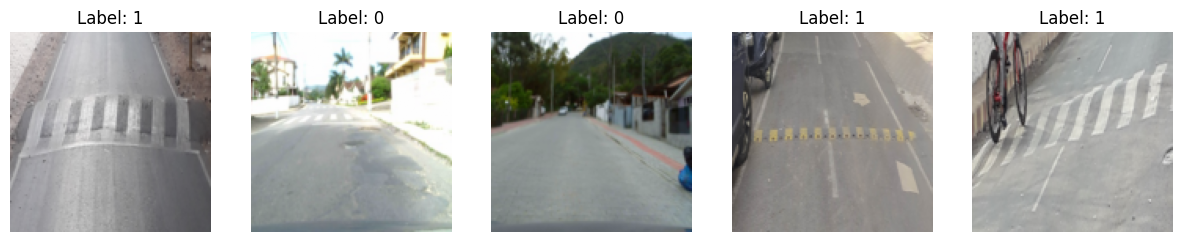

In [4]:

root_dir = r"D:\ML Project(Final Year)\Final Project\DataSet\archive\speed bumps\real"
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

dataset = SpeedBumpsDataset(root_dir, subset="train", transform=transform)

random_indices = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image, label = dataset[idx]  
    image = image.permute(1, 2, 0) 
    image = image.numpy() * 0.5 + 0.5  
    
    ax = axes[i]
    ax.imshow(image)
    ax.axis("off")  
    ax.set_title(f"Label: {label.item()}")

plt.show()

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Случайное отражение по горизонтали
    transforms.RandomRotation(30),  # Случайное вращение
    transforms.Resize((128, 128)),  # Изменение размера
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Нормализация
])

train_dataset = SpeedBumpsDataset(root_dir, subset="train", transform=transform)
val_dataset = SpeedBumpsDataset(root_dir, subset="val", transform=transform)
test_dataset = SpeedBumpsDataset(root_dir, subset="test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = SimpleCNN().to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 регуляризация через weight_decay
criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train() 
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False):
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    model.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_acc = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'device': device
}, 'speed_bump_detector.pth')
print("Model saved successfully!")

# To demonstrate loading and testing:
checkpoint = torch.load('speed_bump_detector.pth')
test_model = SimpleCNN().to(device)
test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.eval()

# Test the loaded model
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = test_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_acc = test_correct / test_total
print(f"Loaded Model - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch [1/10], Train Loss: 0.2076, Train Acc: 0.9230, Val Loss: 0.0375, Val Acc: 0.9853


Epoch [2/10], Train Loss: 0.0370, Train Acc: 0.9927, Val Loss: 0.0240, Val Acc: 0.9853


Epoch [3/10], Train Loss: 0.0337, Train Acc: 0.9881, Val Loss: 0.0367, Val Acc: 0.9853


Epoch [4/10], Train Loss: 0.0233, Train Acc: 0.9927, Val Loss: 0.0215, Val Acc: 0.9963


Epoch [5/10], Train Loss: 0.0286, Train Acc: 0.9936, Val Loss: 0.0162, Val Acc: 0.9963


Epoch [6/10], Train Loss: 0.0317, Train Acc: 0.9918, Val Loss: 0.0418, Val Acc: 0.9890


Epoch [7/10], Train Loss: 0.0235, Train Acc: 0.9908, Val Loss: 0.0709, Val Acc: 0.9780


Epoch [8/10], Train Loss: 0.0313, Train Acc: 0.9908, Val Loss: 0.0201, Val Acc: 0.9963


Epoch [9/10], Train Loss: 0.0164, Train Acc: 0.9936, Val Loss: 0.0174, Val Acc: 0.9890


Epoch [10/10], Train Loss: 0.0140, Train Acc: 0.9963, Val Loss: 0.0671, Val Acc: 0.9817
Test Loss: 0.0648, Test Acc: 0.9912
Model saved successfully!
Test Loss: 0.0648, Test Acc: 0.9912
Model saved successfully!
Loaded Model - Test Loss: 0.0559, Test Accuracy: 0.9912
Loaded Model - Test Loss: 0.0559, Test Accuracy: 0.9912
